# RESULTS
Here I report the resulsts of the training procedure.

In [100]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [112]:
prms = {'L' : 10,                # length of spin chain
        'sites' : [0, 1],        # sites of the subsystem S spins
        'omega' : 1,             # Rabi frequency
        'beta' : 0.001,          # inverse temperature
        'potential' : 0.5,       # interaction of subsystem's S spins
        'potential_' : None,     # interaction of bath spins, if None same as potential
        'T' : 10,                # total time for the evolution
        'dt' : 0.05,             # interval every which save the data
        'cutoff' : 1e-5,         # cutoff for TEBD algorithm
        'im_cutoff' : 1e-7,      # cutoff for TEBD algorithm, img t-e
        'tolerance' : 1e-5,      # Trotter tolerance for TEBD algorithm
        'verbose' : True,        # verbosity of the script
        'num_traj' : 20,         # how many trajectories to do
        # file to save the data
        'fname' : './data/data_tebd.hdf5'
        }

ml_params = {'model_dir': './data/trained_model', # folder where the metadata of the training are stored
             'validation_split' : 0.2,
             'batch_size': 256,
             #'batches_per_epoch': 256,
             'n_epochs': 20,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id'
                 },
             }

### Import the model

In [107]:
from ml.classes import MLLP

name = 'model_L_' + str(prms['L']) + \
        '_V_' + str(int(prms['potential']*1e3)).zfill(4) + \
        '_beta_' + str(int(prms['beta']*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

my_file = Path('./data/trained_model/' + name)
if not my_file.is_file():
    raise Exception('File do not exists!')

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(my_file))

Exception: File do not exists!

### Generate some data

In [113]:
from models import SpinChain

sys_prms = prms.copy()
sys_prms.pop('sites')
sys_prms.pop('potential_')
sys_prms.pop('num_traj')
sys_prms.pop('fname')
sys_prms['verbose'] = False

# evolution of the spin chain
system = SpinChain(**sys_prms)
system.thermalize()
system.evolve()

results = system.return_results()

t=9.95, max-bond=34: 100%|##################################################################################################################################| 200/200 [01:02<00:00,  3.18it/s]


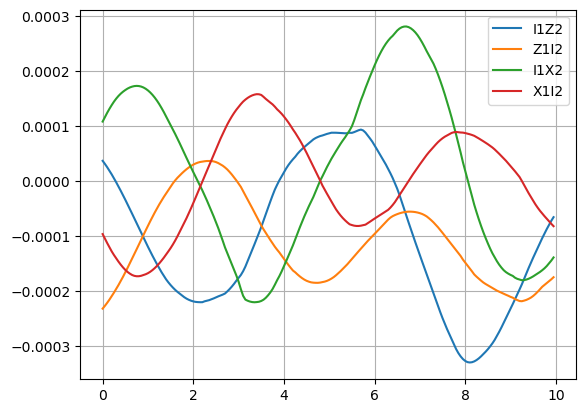

In [114]:
keys = results.keys()
keys = ['I1Z2', 'Z1I2', 'I1X2', 'X1I2']

t = np.arange(0, 10, prms['dt'])

for key in keys:
    plt.plot(t, results[key], label=key)
plt.legend()
plt.grid()

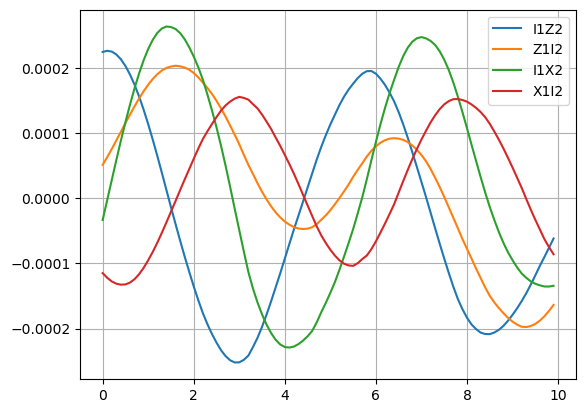

In [111]:
keys = results.keys()
keys = ['I1Z2', 'Z1I2', 'I1X2', 'X1I2']

t = np.arange(0, 10, prms['dt'])

for key in keys:
    plt.plot(t, results[key], label=key)
plt.legend()
plt.grid()

### Generate the dynamics with the model

In [78]:
ml_dyn = results[:1]

X = torch.tensor(ml_dyn.to_numpy())

for i in range(len(results)-1):
    y = model.forward(X)
    ml_dyn = pd.concat((ml_dyn, pd.DataFrame(y.detach().numpy(), columns=ml_dyn.keys())))
    X = y

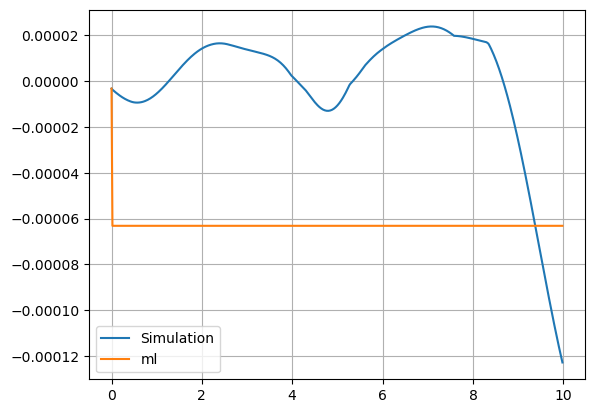

In [99]:
keys = ['Z1X2']

t = np.arange(0, 10, prms['dt'])

for key in keys:
    plt.plot(t, results[key], label='Simulation')
    plt.plot(t, ml_dyn[key], label='ml')
plt.legend()
plt.grid()